In [7]:
# from datasets import load_dataset_builder
# ds_builder = load_dataset_builder("yandex/yambda", "flat-multievent-50m")
# ds_builder.info.features

In [ ]:
from datasets import load_dataset

flat_dataset = load_dataset("yandex/yambda", data_dir="flat/50m", data_files=f"listens.parquet", split="train")


In [34]:
import numpy as np
global_t_max = np.max(flat_dataset.unique("timestamp"))
print(f"Max Train Time: {global_t_max}")

Max Train Time: 26000000


Shuffling dataset to take a random sample for plotting...


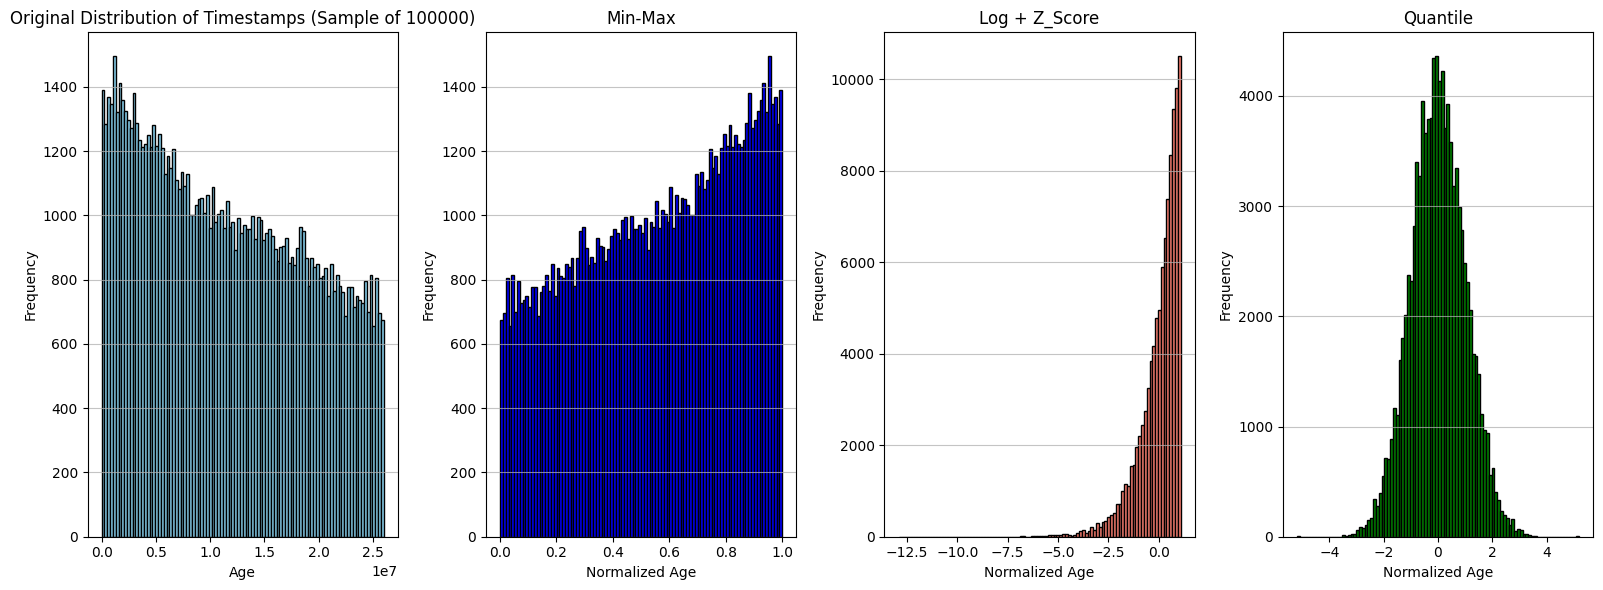

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import QuantileTransformer
from collections import defaultdict

print("Shuffling dataset to take a random sample for plotting...")
sample_size = 100_000
shuffled_dataset = flat_dataset.shuffle(seed=42)
sample = shuffled_dataset.select(range(sample_size))

sample_with_age = sample.map(lambda example: {'age': global_t_max - example['timestamp']})
ages_sample = sample_with_age["age"]
age_sample_np = np.array(ages_sample)

# min-max
age_min = global_t_max - np.min(flat_dataset.unique("timestamp"))
age_max = global_t_max - np.max(flat_dataset.unique("timestamp"))
age_norm = (ages_sample - age_min) / (age_max - age_min)

# log + z_score
log_age_sample = np.log1p(age_sample_np) # log1p = natural log(x + 1)
mean = np.mean(log_age_sample)
std = np.std(log_age_sample)
age_log_z_norm = (log_age_sample - mean) / std

# quantile
qt = defaultdict(lambda: QuantileTransformer(output_distribution='normal', n_quantiles=1000))
age_quantile_norm = qt["age"].fit_transform(age_sample_np.reshape(-1, 1))

# Create a figure with two subplots side-by-side
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(16, 6))


# Plot 1: Original
ax0.hist(ages_sample, bins=100, color='skyblue', edgecolor='black')
ax0.set_title(f'Original Distribution of Timestamps (Sample of {sample_size})')
ax0.set_xlabel('Age')
ax0.set_ylabel('Frequency')
ax0.grid(axis='y', alpha=0.75)

# Plot 1: Min-Max Normalized Distribution
ax1.hist(age_norm, bins=100, color='blue', edgecolor='black')
ax1.set_title('Min-Max')
ax1.set_xlabel('Normalized Age')
ax1.set_ylabel('Frequency')
ax1.grid(axis='y', alpha=0.75)

# Plot 2: Log + Z-Score Normalized Distribution
ax2.hist(age_log_z_norm, bins=100, color='salmon', edgecolor='black')
ax2.set_title('Log + Z_Score')
ax2.set_xlabel('Normalized Age')
ax2.set_ylabel('Frequency')
ax2.grid(axis='y', alpha=0.75)

# Plot 3: Quantile Norm
ax3.hist(age_quantile_norm, bins=100, color='green', edgecolor='black')
ax3.set_title('Quantile')
ax3.set_xlabel('Normalized Age')
ax3.set_ylabel('Frequency')
ax3.grid(axis='y', alpha=0.75)

# Display the plots
plt.tight_layout()
plt.show()

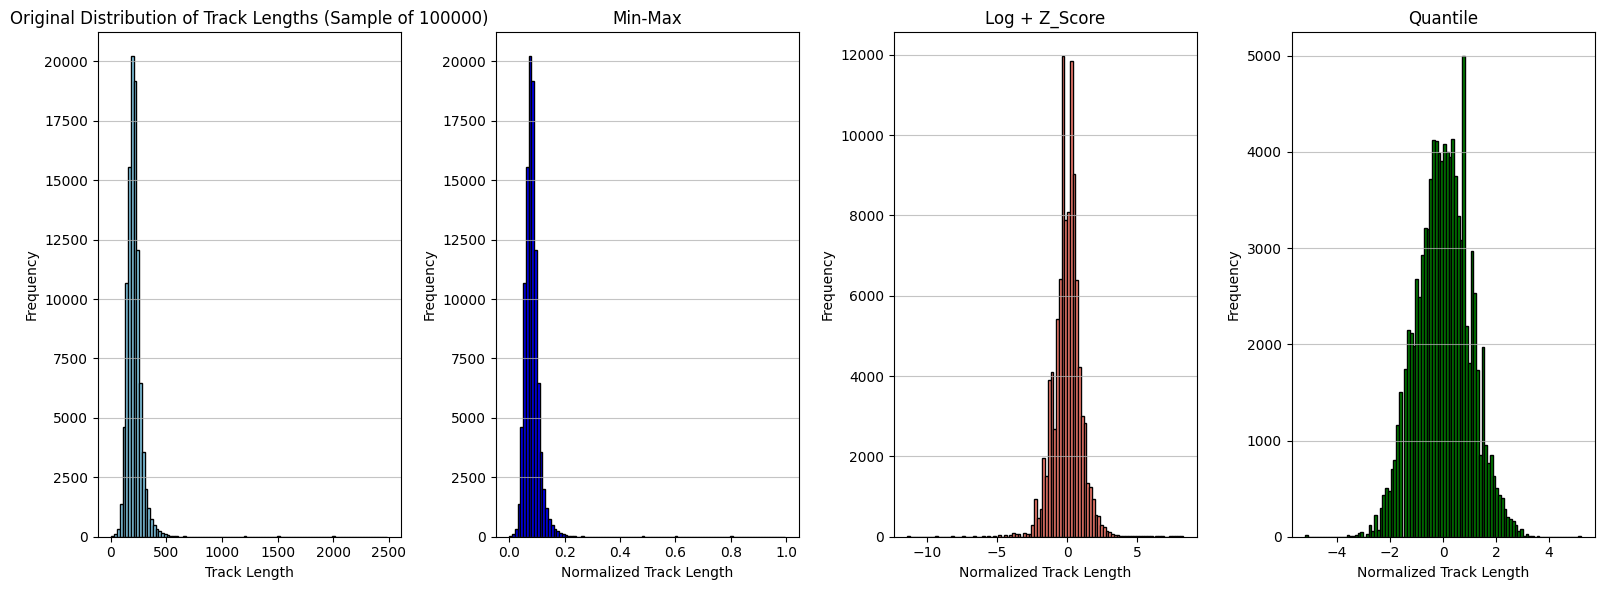

In [36]:

track_sample_np = np.array(sample["track_length_seconds"])

# min-max
track_length_min = np.min(flat_dataset.unique("track_length_seconds"))
track_length_max = np.max(flat_dataset.unique("track_length_seconds"))
track_length_norm = (track_sample_np - track_length_min) / (track_length_max - track_length_min)

# log + z_score
log_track_sample = np.log1p(track_sample_np)
mean = np.mean(log_track_sample)
std = np.std(log_track_sample)
track_length_log_z_norm = (log_track_sample - mean) / std

# quantile
track_length_quantile_norm = qt["track_length"].fit_transform(track_sample_np.reshape(-1, 1))

# Create a figure with two subplots side-by-side
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(16, 6))


# Plot 1: Original
ax0.hist(track_sample_np, bins=100, color='skyblue', edgecolor='black')
ax0.set_title(f'Original Distribution of Track Lengths (Sample of {sample_size})')
ax0.set_xlabel('Track Length')
ax0.set_ylabel('Frequency')
ax0.grid(axis='y', alpha=0.75)

# Plot 1: Min-Max Normalized Distribution
ax1.hist(track_length_norm, bins=100, color='blue', edgecolor='black')
ax1.set_title('Min-Max')
ax1.set_xlabel('Normalized Track Length')
ax1.set_ylabel('Frequency')
ax1.grid(axis='y', alpha=0.75)

# Plot 2: Log + Z-Score Normalized Distribution
ax2.hist(track_length_log_z_norm, bins=100, color='salmon', edgecolor='black')
ax2.set_title('Log + Z_Score')
ax2.set_xlabel('Normalized Track Length')
ax2.set_ylabel('Frequency')
ax2.grid(axis='y', alpha=0.75)

# Plot 3: Quantile Norm
ax3.hist(track_length_quantile_norm, bins=100, color='green', edgecolor='black')
ax3.set_title('Quantile')
ax3.set_xlabel('Normalized Track Length')
ax3.set_ylabel('Frequency')
ax3.grid(axis='y', alpha=0.75)

# Display the plots
plt.tight_layout()
plt.show()

In [37]:
from sklearn.preprocessing import OrdinalEncoder

unique_items = sorted(flat_dataset.unique("item_id"))
unique_uids = sorted(flat_dataset.unique("uid"))

offset = { "item_id": OrdinalEncoder(
                            handle_unknown='use_encoded_value',
                            unknown_value=len(unique_items), 
                            dtype=int
                        ),
            "uid": OrdinalEncoder(
                            handle_unknown='use_encoded_value',
                            unknown_value=len(unique_uids), 
                            dtype=int
                        )
        }
offset["item_id"].fit([[x] for x in unique_items])
offset["uid"].fit([[x] for x in unique_uids])

,"categories categories: 'auto' or a list of array-like, default='auto'Categories (unique values) per feature:- 'auto' : Determine categories automatically from the training data.- list : ``categories[i]`` holds the categories expected in the ith column. The passed categories should not mix strings and numeric values, and should be sorted in case of numeric values.The used categories can be found in the ``categories_`` attribute.",'auto'
,"dtype dtype: number type, default=np.float64Desired dtype of output.",<class 'int'>
,"handle_unknown handle_unknown: {'error', 'use_encoded_value'}, default='error'When set to 'error' an error will be raised in case an unknowncategorical feature is present during transform. When set to'use_encoded_value', the encoded value of unknown categories will beset to the value given for the parameter `unknown_value`. In:meth:`inverse_transform`, an unknown category will be denoted as None... versionadded:: 0.24",'use_encoded_value'
,"unknown_value unknown_value: int or np.nan, default=NoneWhen the parameter handle_unknown is set to 'use_encoded_value', thisparameter is required and will set the encoded value of unknowncategories. It has to be distinct from the values used to encode any ofthe categories in `fit`. If set to np.nan, the `dtype` parameter mustbe a float dtype... versionadded:: 0.24",9238
,"encoded_missing_value encoded_missing_value: int or np.nan, default=np.nanEncoded value of missing categories. If set to `np.nan`, then the `dtype`parameter must be a float dtype... versionadded:: 1.1",nan
,"min_frequency min_frequency: int or float, default=NoneSpecifies the minimum frequency below which a category will beconsidered infrequent.- If `int`, categories with a smaller cardinality will be considered infrequent.- If `float`, categories with a smaller cardinality than `min_frequency * n_samples` will be considered infrequent... versionadded:: 1.3 Read more in the :ref:`User Guide `.",None
,"max_categories max_categories: int, default=NoneSpecifies an upper limit to the number of output categories for each inputfeature when considering infrequent categories. If there are infrequentcategories, `max_categories` includes the category representing theinfrequent categories along with the frequent categories. If `None`,there is no limit to the number of output features.`max_categories` do **not** take into account missing or unknowncategories. Setting `unknown_value` or `encoded_missing_value` to aninteger will increase the number of unique integer codes by one each.This can result in up to `max_categories + 2` integer codes... versionadded:: 1.3 Read more in the :ref:`User Guide `.",None


In [ ]:
from tower import YambdaDataset
import tower
import os


dataset = YambdaDataset("sequential", "50m")

# save
listens = dataset.interaction("listens")
train_ds, val_ds = tower.create_validation_split(listens, validation_days=7, n = 10)

filepath = '../../datasets/yambda/unprocessed'
for ds in ["train", "val"]:
    path = os.path.join(filepath, ds)
    if not path:
        os.makedirs(path)

    train_ds.save_to_disk(path)
    print(f"Dataset saved to {path}")

# load
# from datasets import load_from_disk

# filepath = '../../datasets/yambda/unprocessed'
# train_ds = load_from_disk(os.path.join(filepath, "train"))
# val_ds = load_from_disk(os.path.join(filepath, "val"))
# print("Datasets loaded successfully")

In [ ]:
artist_mapping_ds = dataset.artist_item_mapping()
artist_map = {row['item_id']: row['artist_id'] for row in artist_mapping_ds}

album_mapping_ds = dataset.album_item_mapping()
album_map = {row['item_id']: row['album_id'] for row in album_mapping_ds}

In [40]:
unique_albums = sorted(album_mapping_ds.unique("album_id"))
unique_artists = sorted(artist_mapping_ds.unique("artist_id"))
offset["album_id"] = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=len(unique_albums), dtype=int)
offset["artist_id"] = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=len(unique_artists), dtype=int)
offset["album_id"].fit([[x] for x in unique_albums])
offset["artist_id"].fit([[x] for x in unique_artists])

,"categories categories: 'auto' or a list of array-like, default='auto'Categories (unique values) per feature:- 'auto' : Determine categories automatically from the training data.- list : ``categories[i]`` holds the categories expected in the ith column. The passed categories should not mix strings and numeric values, and should be sorted in case of numeric values.The used categories can be found in the ``categories_`` attribute.",'auto'
,"dtype dtype: number type, default=np.float64Desired dtype of output.",<class 'int'>
,"handle_unknown handle_unknown: {'error', 'use_encoded_value'}, default='error'When set to 'error' an error will be raised in case an unknowncategorical feature is present during transform. When set to'use_encoded_value', the encoded value of unknown categories will beset to the value given for the parameter `unknown_value`. In:meth:`inverse_transform`, an unknown category will be denoted as None... versionadded:: 0.24",'use_encoded_value'
,"unknown_value unknown_value: int or np.nan, default=NoneWhen the parameter handle_unknown is set to 'use_encoded_value', thisparameter is required and will set the encoded value of unknowncategories. It has to be distinct from the values used to encode any ofthe categories in `fit`. If set to np.nan, the `dtype` parameter mustbe a float dtype... versionadded:: 0.24",1293394
,"encoded_missing_value encoded_missing_value: int or np.nan, default=np.nanEncoded value of missing categories. If set to `np.nan`, then the `dtype`parameter must be a float dtype... versionadded:: 1.1",nan
,"min_frequency min_frequency: int or float, default=NoneSpecifies the minimum frequency below which a category will beconsidered infrequent.- If `int`, categories with a smaller cardinality will be considered infrequent.- If `float`, categories with a smaller cardinality than `min_frequency * n_samples` will be considered infrequent... versionadded:: 1.3 Read more in the :ref:`User Guide `.",None
,"max_categories max_categories: int, default=NoneSpecifies an upper limit to the number of output categories for each inputfeature when considering infrequent categories. If there are infrequentcategories, `max_categories` includes the category representing theinfrequent categories along with the frequent categories. If `None`,there is no limit to the number of output features.`max_categories` do **not** take into account missing or unknowncategories. Setting `unknown_value` or `encoded_missing_value` to aninteger will increase the number of unique integer codes by one each.This can result in up to `max_categories + 2` integer codes... versionadded:: 1.3 Read more in the :ref:`User Guide `.",None


In [11]:
def preprocess_sequences(batch):
    """
    Applies all encoding and normalization to a batch of sequences.
    Prevents preprocessing in dataloader
    """
    processed_item_ids = []
    processed_artist_ids = []
    processed_album_ids = []
    processed_track_lengths = []
    
    # The .map(batched=True) gives us a batch of sequences
    for i in range(len(batch["item_id"])):
        # Get sequences for the current user
        item_ids = batch["item_id"][i]
        track_lengths = batch["track_length_seconds"][i]
        
        # Encode IDs
        p_item_ids = offset["item_id"].transform([[x] for x in item_ids]).flatten()
        p_artist_ids = offset["artist_id"].transform([[artist_map.get(item, -1)] for item in item_ids]).flatten()
        p_album_ids = offset["album_id"].transform([[album_map.get(item, -1)] for item in item_ids]).flatten()
        
        # Normalize continuous features
        p_track_lengths = qt["track_length"].transform([[x] for x in track_lengths]).flatten()
        
        processed_item_ids.append(p_item_ids)
        processed_artist_ids.append(p_artist_ids)
        processed_album_ids.append(p_album_ids)
        processed_track_lengths.append(p_track_lengths)

    # Encode the user ID for the batch
    batch["uid"] = offset["uid"].transform([[u] for u in batch["uid"]]).flatten()
    
    # Replace original columns with processed ones
    batch["item_id"] = processed_item_ids
    batch["artist_id"] = processed_artist_ids
    batch["album_id"] = processed_album_ids
    batch["track_length_seconds"] = processed_track_lengths
    
    return batch

In [ ]:
import os

# 1. encode ids for item, uid, artists, albums. necessary to generate embeddings
# 2. normalize track_length
# preprocess data before running dataloader, better to run an expensive tranformation once rather than once for each sample
# save
train_processed = train_ds.map(preprocess_sequences, batched=True, batch_size=1000)
val_processed = val_ds.map(preprocess_sequences, batched=True, batch_size=1000)

filepath = '../../datasets/yambda/processed'
for ds in ["train", "val"]:
    path = os.path.join(filepath, ds)
    if not path:
        os.makedirs(path)

train_processed.save_to_disk(os.path.join(filepath, "train"))
val_processed.save_to_disk(os.path.join(filepath, "val"))


# load
# from datasets import load_from_disk

# filepath = '../../datasets/yambda/processed'
# train_processed = load_from_disk(os.path.join(filepath, "train"))
# print("Dataset loaded successfully:")
# print(train_processed)

Saving the dataset (1/1 shards): 100%|██████████| 7144/7144 [00:00<00:00, 180929.57 examples/s]


In [ ]:
# preprocessing in dataloader must be prevented for efficient batch generation
# instead of using quantile based transform in torch.dataset, I apply log+z_score during forward pass
# this avoids executions of expensive transformations for millions of records on cpu, log_z_score is performed per batch during forward pass on gpu (much more efficient)
# to calculate z_score I need to first find global mean and var for log(age), I simply estimate it hehe

def estimate_log_age_stats(dataset, global_t_max, sample_size=300_000):
    print(f"Sampling {sample_size} records to calculate Age statistics...")
    
    # 1. Take a random sample to represent the global distribution
    # Note: select(range()) is faster than shuffling the whole thing if the dataset is huge
    sample = dataset.shuffle(seed=42).select(range(min(sample_size, len(dataset))))
    
    # 2. Calculate raw ages exactly as your DataLoader will
    # Age = Global Max - Interaction Time
    raw_ages = np.array([global_t_max - x['timestamp'] for x in sample])
    
    # 3. Transform to log-space (natural log)
    # We use log1p (log(1+x)) to safely handle raw_age = 0
    log_ages = np.log1p(raw_ages)
    
    # 4. Calculate Mean and Std of the LOGGED values
    log_mean = np.mean(log_ages)
    log_std = np.std(log_ages)
    
    print(f"Calculation complete.")
    print(f"Log Mean: {log_mean:.6f}")
    print(f"Log Std:  {log_std:.6f}")
    
    return log_mean, log_std

log_age_mean, log_age_std = estimate_log_age_stats(flat_dataset.filter(lambda example: example['timestamp'] < 25395200), global_t_max=25395200)


Filter: 100%|██████████| 46467212/46467212 [01:18<00:00, 595109.55 examples/s]


Sampling 300000 records to calculate Age statistics...
Calculation complete.
Log Mean: 15.874020
Log Std:  1.090574


In [42]:
import torch

print(f"Define embedding_dim_size as log_2(len(unique_vals)): {torch.log2(torch.tensor([len(unique_uids), len(unique_items), len(unique_albums), len(unique_artists)]) + 1)}")
print(f"unique_uids: {len(unique_uids)}\tunique_items: {len(unique_items)}\tunique_albums: {len(unique_albums)}\tunique_artists: {len(unique_artists)}")

Define embedding_dim_size as log_2(len(unique_vals)): tensor([13.1735, 19.7425, 21.6833, 20.3027])
unique_uids: 9238	unique_items: 877168	unique_albums: 3367691	unique_artists: 1293394


In [88]:
# use flat dataset, album, and artist mappings to generate train and validation item data, one for each unique item id
train_flat = flat_dataset.filter(lambda example: example['timestamp'] < 25395200).flatten_indices()
train_item_ds = tower.create_item_data(train_flat, artist_mapping_ds, album_mapping_ds, offset, qt)

unique_items: 862091
Executing lazy plan (collecting results)...
Collected 862091 unique items.
Applying transforms...


Generate item data in order to train and populate index table. Train index table using items in training dataset, insert items from both train and validation datasets (train.ipynb).

In [ ]:
from datasets import Dataset as HFDataset

val_flat = flat_dataset.filter(lambda example: example['timestamp'] >= 25395200).flatten_indices()
val_item_ds = tower.create_item_data(val_flat, artist_mapping_ds, album_mapping_ds, offset, qt)

train_ids = train_item_ds.to_polars().select("candidate_id")
val_pl = val_item_ds.to_polars()

# Perform an anti-join: keeps rows in val that DO NOT exist in train
unique_val_pl = val_pl.join(train_ids, on="candidate_id", how="anti")

print(f"Items in Val after removing train overlap: {len(unique_val_pl)}")
val_item_ds = HFDataset.from_polars(unique_val_pl)

# rmoving items that have already appeared in train to avoid dup values inside index table

unique_items: 189745
Executing lazy plan (collecting results)...
Collected 189745 unique items.
Applying transforms...
Items in Val after removing train overlap: 15077


In [90]:
filepath = '../../datasets/yambda/items'
for ds in ["train", "val"]:
    path = os.path.join(filepath, ds)
    if not path:
        os.makedirs(path)

train_item_ds.save_to_disk(os.path.join(filepath, "train"))
print(f"Dataset saved to {os.path.join(filepath, "train")}")

val_item_ds.save_to_disk(os.path.join(filepath, "val"))
print(f"Dataset saved to {os.path.join(filepath, "val")}")

Saving the dataset (1/1 shards): 100%|██████████| 862091/862091 [00:00<00:00, 4953004.69 examples/s]


Dataset saved to ../../datasets/yambda/items/train


Saving the dataset (1/1 shards): 100%|██████████| 15077/15077 [00:00<00:00, 210428.40 examples/s]

Dataset saved to ../../datasets/yambda/items/val


Quick note to myself that numpy array is more memory efficient than reqular python list of tuples

In [98]:
import sys
import numpy as np

# Create a large list of tuples
num_samples = 1_000_000
list_of_tuples = [(i, i + 1) for i in range(num_samples)]

# Create a NumPy array with the same data
numpy_array = np.array(list_of_tuples, dtype=np.int32)

# Calculate memory usage
# sys.getsizeof() on a list gives the size of the list of pointers, not the full size.
# We need to sum the size of the integers themselves for a more accurate (though still underestimated) size.
list_size = sys.getsizeof(list_of_tuples) + sum(sys.getsizeof(t) + sys.getsizeof(t[0]) + sys.getsizeof(t[1]) for t in list_of_tuples)
numpy_size = numpy_array.nbytes

print(f"Number of samples: {num_samples}")
print(f"Estimated memory for list of tuples: {list_size / 1e6:.2f} MB")
print(f"Memory for NumPy array:             {numpy_size / 1e6:.2f} MB")
print(f"NumPy is about {int(list_size / numpy_size)}x more memory efficient here.")

Number of samples: 1000000
Estimated memory for list of tuples: 120.45 MB
Memory for NumPy array:             8.00 MB
NumPy is about 15x more memory efficient here.
